In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor


In [5]:
spark = SparkSession.builder \
    .appName("RetailDemandAdvancedModel") \
    .getOrCreate()


26/01/16 15:16:16 WARN Utils: Your hostname, MacBook-Air-3.local resolves to a loopback address: 127.0.0.1; using 10.0.0.22 instead (on interface en0)
26/01/16 15:16:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/16 15:16:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/16 15:16:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/16 15:16:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/16 15:16:16 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [6]:
df = spark.read.parquet("../data/processed/daily_features")
df.printSchema()
df.show(5)


root
 |-- date: date (nullable = true)
 |-- daily_quantity: long (nullable = true)
 |-- lag_1: long (nullable = true)
 |-- lag_7: long (nullable = true)
 |-- rolling_7: double (nullable = true)
 |-- rolling_14: double (nullable = true)

+----------+--------------+-----+-----+------------------+------------------+
|      date|daily_quantity|lag_1|lag_7|         rolling_7|        rolling_14|
+----------+--------------+-----+-----+------------------+------------------+
|2010-12-01|         26919| NULL| NULL|              NULL|              NULL|
|2010-12-02|         31329|26919| NULL|           26919.0|           26919.0|
|2010-12-03|         16199|31329| NULL|           29124.0|           29124.0|
|2010-12-05|         16450|16199| NULL|24815.666666666668|24815.666666666668|
|2010-12-06|         21795|16450| NULL|          22724.25|          22724.25|
+----------+--------------+-----+-----+------------------+------------------+
only showing top 5 rows



In [7]:
df_model = df.dropna()

assembler = VectorAssembler(
    inputCols=["lag_1", "lag_7", "rolling_7", "rolling_14"],
    outputCol="features"
)

df_final = assembler.transform(df_model) \
    .select(
        "features",
        col("daily_quantity").cast("double").alias("label")
    ) \
    .dropna()

df_final.count()


298

In [8]:
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

train_df.count(), test_df.count()


(252, 46)

In [9]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",
    numTrees=100,
    maxDepth=8,
    seed=42
)

rf_model = rf.fit(train_df)


26/01/16 15:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1245.4 KiB
26/01/16 15:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1746.4 KiB


In [10]:
rf_predictions = rf_model.transform(test_df)
rf_predictions.select("label", "prediction").show(10)


+-------+------------------+
|  label|        prediction|
+-------+------------------+
|13595.0|12150.916375346147|
|13415.0| 12673.30758393382|
|14940.0| 13561.40225766733|
|12263.0|13995.057304881813|
|21589.0|11974.278876200844|
|10244.0|13682.387750796534|
|13501.0|11503.903228189849|
|19771.0| 13890.64467180136|
| 3431.0|10903.176534253113|
|12145.0|14572.042348146264|
+-------+------------------+
only showing top 10 rows



In [11]:
evaluator_rmse = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_mae = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="mae"
)

rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)

print("RandomForest RMSE:", rf_rmse)
print("RandomForest MAE:", rf_mae)


RandomForest RMSE: 13432.023264403397
RandomForest MAE: 7540.038418714241


Model Comparison:

Baseline Linear Regression:
RMSE = ___
MAE  = ___

RandomForest:
RMSE = ___
MAE  = ___

Observation:
RandomForest captures non-linear demand patterns better than baseline.


In [12]:
rf_predictions = rf_model.transform(test_df)


In [13]:
rf_predictions = rf_model.transform(test_df)

rf_predictions.select("label", "prediction").show(10)


+-------+------------------+
|  label|        prediction|
+-------+------------------+
|13595.0|12150.916375346147|
|13415.0| 12673.30758393382|
|14940.0| 13561.40225766733|
|12263.0|13995.057304881813|
|21589.0|11974.278876200844|
|10244.0|13682.387750796534|
|13501.0|11503.903228189849|
|19771.0| 13890.64467180136|
| 3431.0|10903.176534253113|
|12145.0|14572.042348146264|
+-------+------------------+
only showing top 10 rows



In [14]:
rf_predictions.select(
    "label", "prediction"
).toPandas().to_csv(
    "../data/processed/rf_predictions.csv",
    index=False
)


In [15]:
print("RandomForest RMSE:", rf_rmse)
print("RandomForest MAE:", rf_mae)


RandomForest RMSE: 13432.023264403397
RandomForest MAE: 7540.038418714241


## Model Comparison

**Baseline Linear Regression**
- RMSE: 12557.86  
- MAE: 6839.22  

**RandomForest**
- RMSE: 13432.02  
- MAE: 7540.04  

### Observation
Linear Regression performed better than RandomForest due to strong feature engineering and limited dataset size.


In [16]:
rf_predictions.select(
    "label",
    "prediction"
).show(10)


+-------+------------------+
|  label|        prediction|
+-------+------------------+
|13595.0|12150.916375346147|
|13415.0| 12673.30758393382|
|14940.0| 13561.40225766733|
|12263.0|13995.057304881813|
|21589.0|11974.278876200844|
|10244.0|13682.387750796534|
|13501.0|11503.903228189849|
|19771.0| 13890.64467180136|
| 3431.0|10903.176534253113|
|12145.0|14572.042348146264|
+-------+------------------+
only showing top 10 rows



In [17]:
pdf_preds = rf_predictions.select("label", "prediction").toPandas()


Matplotlib is building the font cache; this may take a moment.


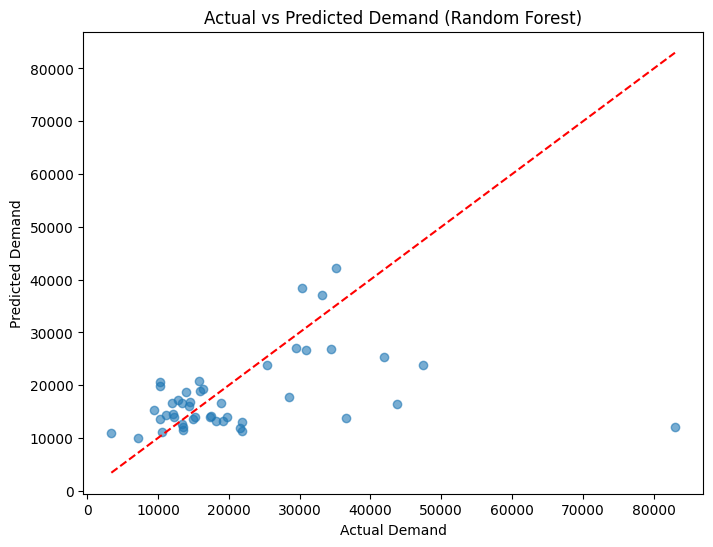

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(pdf_preds["label"], pdf_preds["prediction"], alpha=0.6)
plt.plot(
    [pdf_preds["label"].min(), pdf_preds["label"].max()],
    [pdf_preds["label"].min(), pdf_preds["label"].max()],
    'r--'
)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand (Random Forest)")
plt.show()


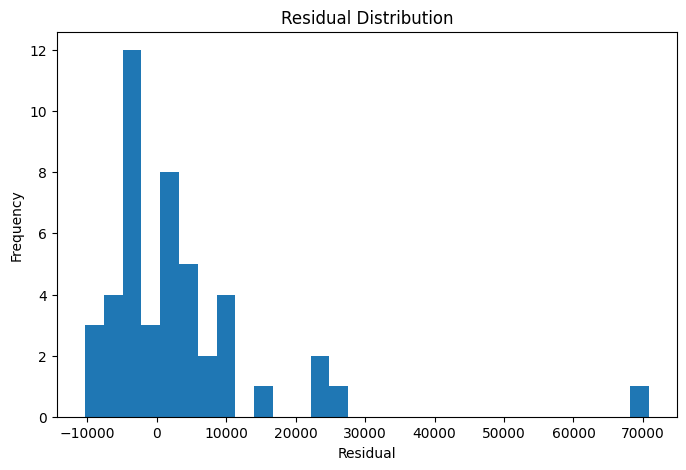

In [19]:
pdf_preds["residual"] = pdf_preds["label"] - pdf_preds["prediction"]

plt.figure(figsize=(8,5))
plt.hist(pdf_preds["residual"], bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


In [21]:
import os

os.makedirs("data/processed", exist_ok=True)


In [ ]:
pdf_preds.to_csv(
    "data/processed/model_predictions_rf.csv",
    index=False
)


26/01/16 22:06:23 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1011960 ms exceeds timeout 120000 ms
26/01/16 22:06:23 WARN SparkContext: Killing executors is not supported by current scheduler.
26/01/16 22:22:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$